# Listings

In [1]:
import pandas as pd

df_2020_03 = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2020-03-16/data/listings.csv.gz', compression='gzip')
df_2019_18 = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2019-10-18/data/listings.csv.gz', compression='gzip')
df_2018_10 = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2018-10-11/data/listings.csv.gz', compression='gzip')
df_2017_10 = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2017-10-06/data/listings.csv.gz', compression='gzip')
df_2016_09 = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2016-09-07/data/listings.csv.gz', compression='gzip')
df_2015_10 = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2015-10-03/data/listings.csv.gz', compression='gzip')

df_original_listings = pd.concat([df_2020_03, df_2019_18, df_2018_10, df_2017_10, df_2016_09, df_2015_10]).drop_duplicates('id')
print('Len total =', len(df_original_listings))

df_listings = df_original_listings.copy()
df_listings = df_listings.replace('nan', '', regex=True)
df_listings['summary'] = df_listings['summary'].astype(str)
df_listings['space'] = df_listings['space'].astype(str)
df_listings['description'] = df_listings['description'].astype(str)
df_listings['neighborhood_overview'] = df_listings['neighborhood_overview'].astype(str)
df_listings['host_neighbourhood'] = df_listings['host_neighbourhood'].astype(str)
df_listings['neighbourhood_cleansed'] = df_listings['neighbourhood_cleansed'].astype(str)
df_listings['notes'] = df_listings['notes'].astype(str)
df_listings['review_scores_rating'] = df_listings['review_scores_rating'].astype(float)
df_listings = df_listings[df_listings['review_scores_rating'].notna()]
print(len(df_listings))
df_listings['review_scores_rating']

Len total = 12480
9684


0        99.0
1        95.0
2        96.0
3        93.0
4        95.0
        ...  
2552     96.0
2554     99.0
2555     99.0
2556    100.0
2557     87.0
Name: review_scores_rating, Length: 9684, dtype: float64

In [2]:
from collections import Counter
from itertools import chain
import itertools
import string
import re
import spacy

# Download the natural language dataset for english, if this is the first run
# !python -m spacy download en_core_web_sm

# Load spacy
nlp = spacy.load('en_core_web_sm')

# Add in common words that occurr in all listings, that really don't mean anything useful here
nlp.Defaults.stop_words |= {'many', 'great', 'nearby', 'short', 'major', 'north', 'south', 'east', 'west', 'easy', 'true', 'local', 'public', 'mi', 'several', 'such', 'main', 'other'}

print('great' in nlp.Defaults.stop_words)

# Creates a Counter of adjectives used in the "neighborhood overview" field of all listings
# within the neighborhood name provided. 
def get_neighborhood_adjectives(name):
  
  # List of the "neighborhood_overview" field for all listings for this neighborhood
  overviews = df_listings.loc[df_listings['neighbourhood_cleansed'] == name]['neighborhood_overview']
  
  list_overviews = '  '.join([overview for overview in overviews])
    
  # Combine all overviews into one, and load it into spacy
  text = nlp(list_overviews)
  
  # Get the adjectives
  adjectives = [token.lemma_ for token in text if token.pos_ == "ADJ" and not token.is_stop]
  
  # Count the adjectives
  counter = Counter(adjectives)
  
  # Remove pronoun forms
  counter.pop('-PRON-', None)
  
  return (len(overviews), counter)

  
# north_end = get_neighborhood_adjectives('North End')
# print('Listings in north end:', north_end[0])
# print('North end is:', north_end[1])

True


In [3]:
# for neighborhood in df_listings['neighbourhood_cleansed'].unique():
#     ads = get_neighborhood_adjectives(neighborhood)
#     print(neighborhood, ':', ads[0])
#     print(neighborhood, 'is:', ads[1].most_common(5))

# Reviews

In [4]:
import pandas as pd

reviews_2020_03 = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2020-03-16/data/reviews.csv.gz', compression='gzip')
reviews_2019_18 = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2019-10-18/data/reviews.csv.gz', compression='gzip')
reviews_2018_10 = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2018-10-11/data/reviews.csv.gz', compression='gzip')
reviews_2017_10 = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2017-10-06/data/reviews.csv.gz', compression='gzip')
reviews_2016_09 = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2016-09-07/data/reviews.csv.gz', compression='gzip')
reviews_2015_10 = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2015-10-03/data/reviews.csv.gz', compression='gzip')

df_reviews = pd.concat([reviews_2020_03, reviews_2019_18, reviews_2018_10, reviews_2017_10, reviews_2016_09, reviews_2015_10])
df_reviews['comments'] = df_reviews['comments'].astype(str)
print('Len total =', len(df_reviews))

Len total = 794377


# Vibe Factor Calculations

In [5]:
# Load spacy
import spacy
nlp = spacy.load('en_core_web_sm')

# Calculates the neighborhood accuracy statistic for a listing
# Neighborhood accuracy is the dot product between the neighborhood description
# and the reviews left for the place. This metric is greatest when the experience
# of the visitors most matched the vibe that was portrayed by the listing.

# Neighborhood accuracy is calculated as the sum of the number of adjectives that appear 
# in both the neighborhood description and in the reviews for a listing,
# weighted by the frequency by which those adjectives occur in all 
# neighborhood descriptions within that neighborhood.

# calc_neighborhood_accuracy(comments_list) takes in a list of strings as the comments
# for that listing. It returns a scalar neighborhood accuracy score.
def calc_neighborhood_accuracy(neighborhood_adjectives, neighborhood_frequencies, comments_list):
  neighborhood_accuracy = 0

  # Comments, excluding punctuation and special characters
  listing_comments = re.sub('[^\w\s]+', '', ' '.join(comments_list)).split()
  
  # Count up the frequencies of these words
  comment_freq = Counter(listing_comments)
  comment_words = list(comment_freq.keys())

  # Dot product time doo doo doo doo doo
  for i in range(len(neighborhood_adjectives)):
    if (neighborhood_adjectives[i] in comment_words):
      neighborhood_accuracy += neighborhood_frequencies[i] * comment_freq[neighborhood_adjectives[i]]

  neighborhood_accuracy /= len(comments_list)

  return neighborhood_accuracy

# Calculates the mean sentiment of all reviews for a listing.
# def calc_happiness(comments_list):
  

# Generate all data

In [39]:
def gen_data():
  vibedict = []
  for neighborhood in df_listings['neighbourhood_cleansed'].unique():

    # Primary adjectives and their frequencies, used by all listings within to describe this neighborhood
    neighborhood_adjectives = get_neighborhood_adjectives(neighborhood)[1]
    adjectives = list(neighborhood_adjectives)
    frequencies = [neighborhood_adjectives[adjective] for adjective in adjectives]

    # for each listing within this neighborhood
    for listing_id in df_listings.loc[df_listings['neighbourhood_cleansed'] == neighborhood]['id']:
      
      # List of comments for that listing
      comments_list = df_reviews.loc[df_reviews['listing_id'] == listing_id]['comments'].tolist()
      if len(comments_list) == 0:
        continue

      # Neighborhood accuracy metric ("Consistency")
      consistency = calc_neighborhood_accuracy(adjectives, frequencies, comments_list)

      # Average rating ("Enjoyability")
      enjoyability = df_listings.loc[df_listings['id'] == listing_id]['review_scores_rating'].values[0]
      
      # Number of ratings ("Popularity")
      popularity = len(comments_list)
      
      # Add this listing and its metrics to the dictionary
      vibedict.append({'listing_id': listing_id,
                       'lat': df_listings.loc[df_listings['id'] == listing_id]['latitude'].values[0],
                       'lon': df_listings.loc[df_listings['id'] == listing_id]['longitude'].values[0],
                       'enjoyability': enjoyability,
                       'consistency': consistency,
                       'popularity': popularity})

  vibetable = pd.DataFrame(columns=['listing_id', 'lat', 'lon', 'enjoyability',  'consistency', 'popularity'])
  vibetable = vibetable.append(vibedict, ignore_index=True)
  return vibetable

In [110]:
vibetable = gen_data()

In [111]:
import numpy as np

scaled_table = vibetable.copy()

scaled_table['consistency'] = (vibetable['consistency'] - np.quantile(vibetable['consistency'], 0.01)).clip(lower=0)
scaled_table['consistency'] = (scaled_table['consistency'] / np.quantile(scaled_table['consistency'], 0.99)).clip(upper=1)

scaled_table['popularity'] = (vibetable['popularity'] - np.quantile(vibetable['popularity'], 0.0000001)).clip(lower=0)
scaled_table['popularity'] = (scaled_table['popularity'] / np.quantile(scaled_table['popularity'], 0.99)).clip(upper=1)

scaled_table['enjoyability'] = (vibetable['enjoyability'] - np.quantile(vibetable['enjoyability'], 0.01)).clip(lower=0)
scaled_table['enjoyability'] = scaled_table['enjoyability'] / np.amax(scaled_table['enjoyability'])



In [117]:
scaled_table.to_csv("dist/data/vibetable.csv", index=False)
scaled_table.to_json("dist/data/vibetable.json", orient='index')

(array([1.000e+02, 1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 1.200e+02, 0.000e+00, 2.000e+00, 3.000e+00, 8.000e+00,
        8.000e+00, 5.000e+00, 0.000e+00, 1.400e+01, 7.000e+00, 3.000e+00,
        5.000e+01, 6.000e+00, 1.200e+01, 5.200e+01, 1.200e+01, 3.100e+01,
        3.000e+01, 2.800e+01, 3.500e+01, 1.800e+01, 4.520e+02, 3.500e+01,
        5.600e+01, 1.090e+02, 0.000e+00, 1.210e+02, 1.410e+02, 1.140e+02,
        2.690e+02, 2.550e+02, 2.520e+02, 5.650e+02, 3.180e+02, 3.890e+02,
        6.100e+02, 4.220e+02, 5.610e+02, 6.740e+02, 6.450e+02, 6.870e+02,
        3.860e+02, 2.074e+03]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <a list of 50 Patch objects

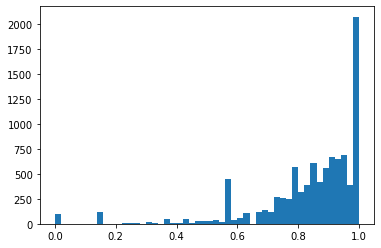

In [118]:
import matplotlib.pyplot as plt
# plt.hist(scaled_table['enjoyability'], bins=50)
# plt.show()
plt.hist(scaled_table['enjoyability'], bins=50)